In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
df = pd.read_excel('merged17-20.xlsx')
df.head()

,Неделя,Всього захворіло,у т.ч.діти до 17 років,18 - 29,30 - 64,65 та старші,Госпіталізація,Показник захворюваності,Епідпоріг,Перевищення епідпорогу (%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.0,7891.0,5836.0,639.0,1147.0,269.0,142.0,291.94,527.44,-44.65
2,42.0,6736.0,4928.0,517.0,1029.0,262.0,160.0,249.21,541.73,-54.00
3,43.0,6835.0,4392.0,796.0,1307.0,340.0,147.0,252.87,634.05,-60.12
4,44.0,7595.0,4965.0,870.0,1377.0,383.0,160.0,280.99,568.92,-50.61


In [15]:
df = df.iloc[1:]
df = df.iloc[64:, :]
dic = list(df.columns)
col_dict = dict(zip(dic, ['week', 'total','upto17', '18-29', '30-64', '65+', 'hospital', 'indicator', 'epid', 'epid excess']))
df2 = df.rename(columns = col_dict, inplace = False)
df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']] \
= df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']].astype(int)
df2.head()

,week,total,upto17,18-29,30-64,65+,hospital,indicator,epid,epid excess
65,41,4950,3103,475,1081,291,132,184.81,422.26,-56.23
66,42,4028,2436,418,922,252,112,150.39,422.26,-64.38
67,43,4832,2948,487,1056,341,142,180.41,422.26,-57.28
68,44,4113,2443,374,1011,285,142,154.63,422.26,-63.38
69,45,4467,2568,447,1121,331,130,167.93,422.26,-60.23


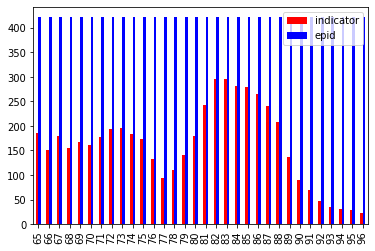

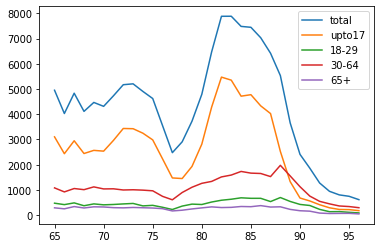

In [16]:
df2.iloc[:, 7:9].plot(kind='bar', color=['red', 'blue'])
df3 = df2.iloc[:, 1:6]
df3.plot()

<Figure size 432x288 with 0 Axes>

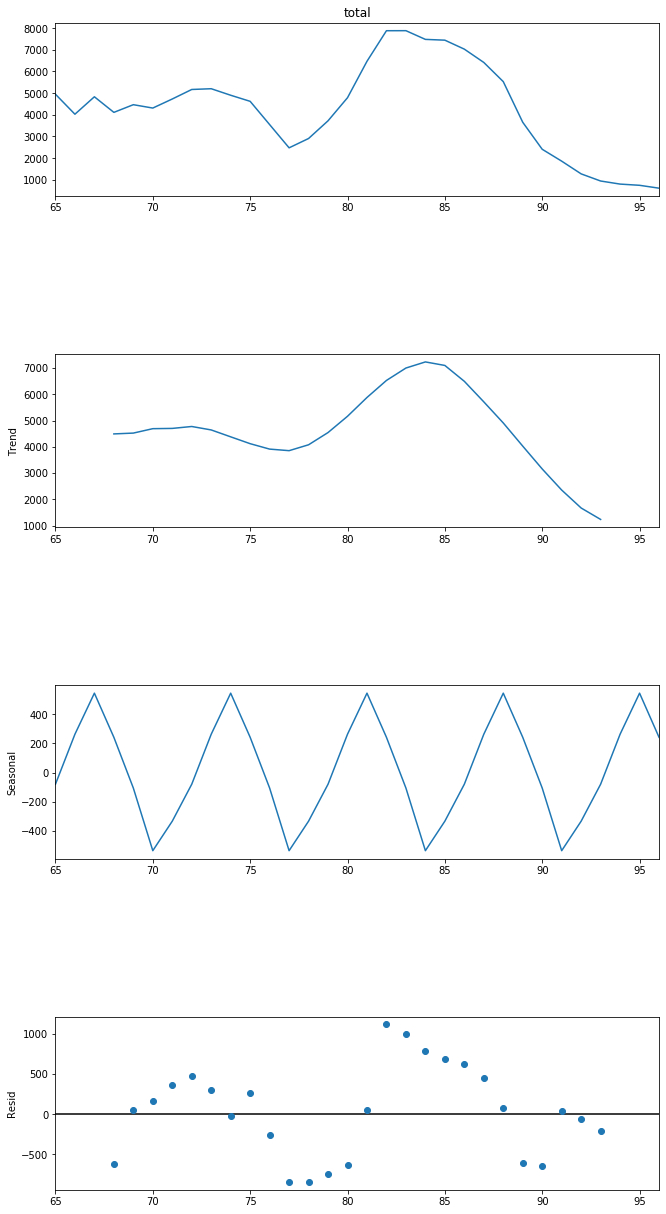

In [17]:
decomposition = seasonal_decompose(df2.total, period=7)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 20)

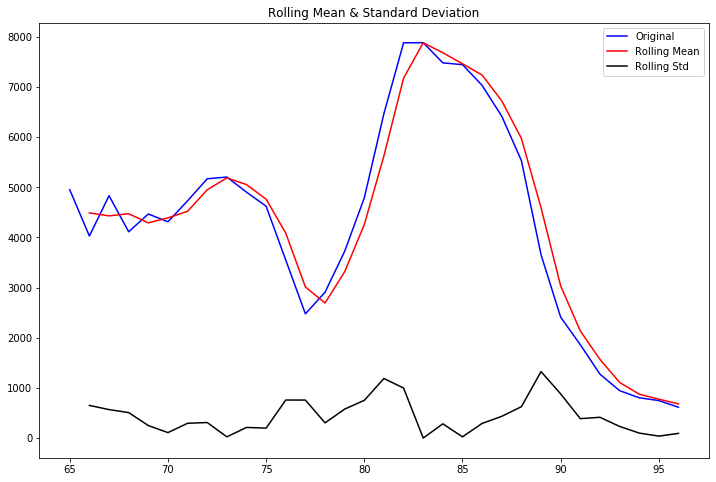

Results of Dickey-Fuller Test:
Test Statistic                 -0.955262
p-value                         0.769230
#Lags Used                      5.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [18]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=2).mean()
    rolstd = pd.Series(timeseries).rolling(window=2).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.total)

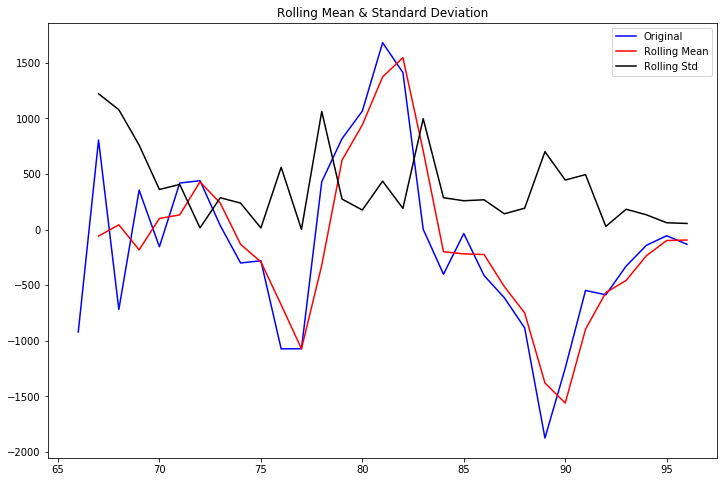

Results of Dickey-Fuller Test:
Test Statistic                 -2.458993
p-value                         0.125773
#Lags Used                      3.000000
Number of Observations Used    27.000000
Critical Value (1%)            -3.699608
Critical Value (5%)            -2.976430
Critical Value (10%)           -2.627601
dtype: float64


In [19]:
#  first difference
df2['first_diff'] = df2.total - df2.total.shift(1)
test_stationarity(df2.first_diff.dropna(inplace=False))

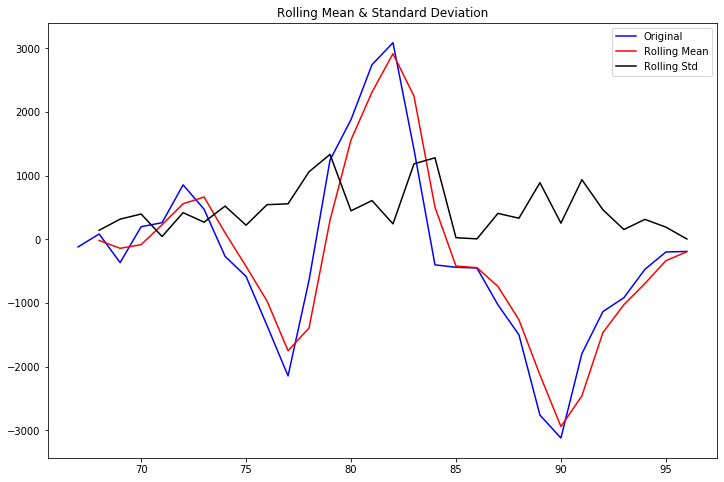

Results of Dickey-Fuller Test:
Test Statistic                 -2.065627
p-value                         0.258559
#Lags Used                      5.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


In [20]:
#  seasonal difference
df2['seasonal_diff'] = df2.total - df2.total.shift(2)
test_stationarity(df2.seasonal_diff.dropna(inplace=False))

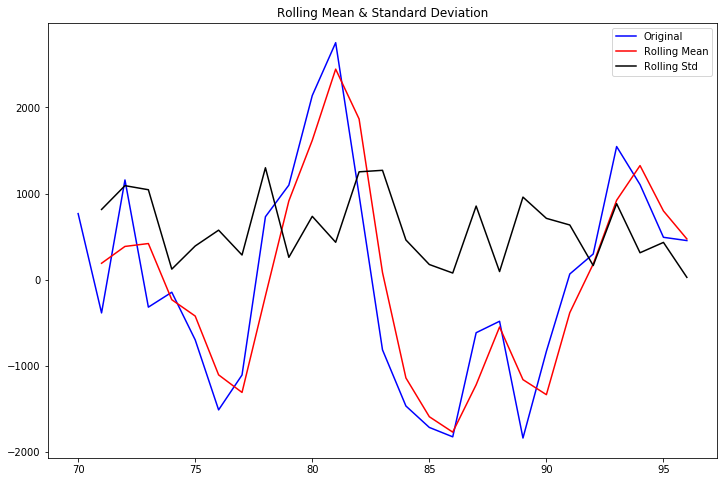

Results of Dickey-Fuller Test:
Test Statistic                 -2.689161
p-value                         0.075933
#Lags Used                      6.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


In [21]:
#  seasonal first difference
df2['seasonal_first_diff'] = df2.first_diff - df2.first_diff.shift(4) # пробую месячную сезонность
test_stationarity(df2.seasonal_first_diff.dropna(inplace=False))

In [22]:
#  brute force calculating parameters for SARIMA
#  uncomment for calculate again

"""
import itertools


p = range(0,3)
q = range(0,3)
d = range(0,2)
s = (4, ) # means season duration
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df2.first_diff,
                          order=param,
                          seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
        except:
            continue

print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
pdq, seasonal_pdq, aic = param, param_seasonal, results.aic

"""

# Calculated for this model pdq=(2, 1, 2), seasonal_pdq=(2, 1, 2, 4)


"\nimport itertools\n\n\np = range(0,3)\nq = range(0,3)\nd = range(0,2)\ns = (4, ) # means season duration\n# list of all parameter combos\npdq = list(itertools.product(p, d, q))\nseasonal_pdq = list(itertools.product(p, d, q, s))\n\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = SARIMAX(df2.first_diff,\n                          order=param,\n                          seasonal_order=param_seasonal)\n            results = mod.fit(max_iter = 50, method = 'powell')\n        except:\n            continue\n\nprint('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))\npdq, seasonal_pdq, aic = param, param_seasonal, results.aic\n\n"

In [23]:
pdq, seasonal_pdq = (2, 1, 2), (2, 1, 2, 4)
mod = SARIMAX(df2.total, trend='n', order=pdq, seasonal_order=seasonal_pdq)
results = mod.fit()
print(results.summary())

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                             total   No. Observations:                   32
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 4)   Log Likelihood                -216.997
Date:                           Fri, 05 Nov 2021   AIC                            451.995
Time:                                   23:53:57   BIC                            463.657
Sample:                                        0   HQIC                           455.463
                                            - 32                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8466      0.467      1.811      0.070      -0.070       1.763
ar.L2         -0.6152      0.377     -1.634

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


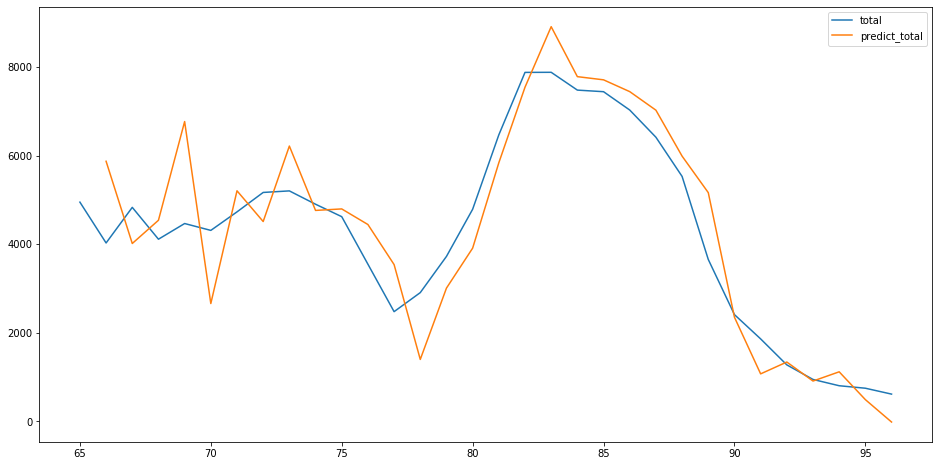

In [24]:
df2['predict_total'] = results.predict(start=1, end=32, dynamic=False)  
df2[['total', 'predict_total']].plot(figsize=(16, 8))

In [27]:
pdq, seasonal_pdq = (2, 1, 2), (2, 1, 2, 32)
mod = SARIMAX(df2.total, trend='n', order=pdq, seasonal_order=seasonal_pdq)
results = mod.fit()
print(results.summary())

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                              total   No. Observations:                   32
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 32)   Log Likelihood                   0.000
Date:                            Fri, 05 Nov 2021   AIC                             18.000
Time:                                    23:59:35   BIC                                nan
Sample:                                         0   HQIC                               nan
                                             - 32                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0         -0        nan        nan           0          -0
ar.L2               0         -0   

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/eval_measures.py:406: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/eval_measures.py:431: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2939: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2939: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:468: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:1

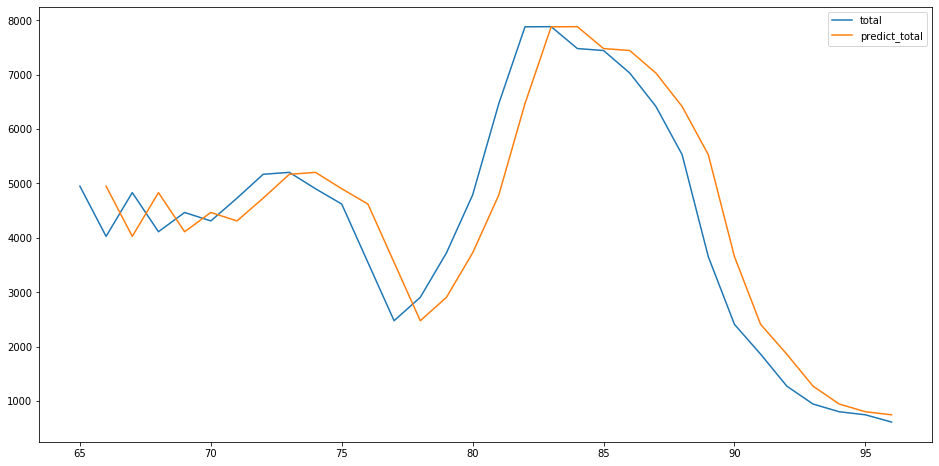

In [28]:
df2['predict_total'] = results.predict(start=1, end=32, dynamic=False)  
df2[['total', 'predict_total']].plot(figsize=(16, 8))